# **100d_Glove**

In [ ]:
mount drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Sentiment analysis/project 2024/Dataset-20231210T071705Z-001/Dataset/train.csv")
del df['Unnamed: 0']
print(df.head())

                                              review sentiment
0  One reviewer mentioned after watching Oz episo...  positive
1  A wonderful little production The filming tech...  positive
2  I thought wonderful way spend time hot summer ...  positive
3  Basically s family little boy Jake think s zom...  negative
4  Petter Mattei Love Time Money visually stunnin...  positive


In [ ]:
def sentiment(text):
  if text=='positive':
    return 1
  else:
    return 0
df['sentiment']=df['sentiment'].apply(sentiment)
df.head()

,review,sentiment
0,One reviewer mentioned after watching Oz episo...,1
1,A wonderful little production The filming tech...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically s family little boy Jake think s zom...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [ ]:
# Load GloVe embeddings
vocab = GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:38, 5.43MB/s]                           
100%|█████████▉| 399999/400000 [00:31<00:00, 12622.79it/s]


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        review = self.data.iloc[idx]['review']
        sentiment = self.data.iloc[idx]['sentiment']

        # Convert review to GloVe embeddings
        tokens = review.split()
        vectors = [vocab.vectors[vocab.stoi[token]] for token in tokens if token in vocab.stoi]
        if len(vectors) > 0:
            embeddings = torch.stack(vectors).mean(0)
        else:
            embeddings = torch.zeros(vocab.dim)

        return embeddings, sentiment



In [ ]:
dataset = SentimentDataset(df)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
import pandas as pd
df1 = pd.read_csv("/content/drive/MyDrive/Sentiment analysis/project 2024/Dataset-20231210T071705Z-001/Dataset/val.csv")
del df1['Unnamed: 0']
print(df1.head())

                                              review sentiment
0  This movie bad start The purpose movie Angela ...  negative
1  God I never felt insulted whole life with crap...  negative
2  Not fan Coen Brothers George Clooney anyone se...  positive
3  The movie Andaz Apna Apna my book top intellig...  positive
4  I say I really looking forward watching film f...  negative


In [ ]:
def sentiment(text):
  if text=='positive':
    return 1
  else:
    return 0
df1['sentiment']=df1['sentiment'].apply(sentiment)
df1.head()

,review,sentiment
0,This movie bad start The purpose movie Angela ...,0
1,God I never felt insulted whole life with crap...,0
2,Not fan Coen Brothers George Clooney anyone se...,1
3,The movie Andaz Apna Apna my book top intellig...,1
4,I say I really looking forward watching film f...,0


In [ ]:
#test_dataloader
test_dataset = SentimentDataset(df1)
test_dataloader = DataLoader(test_dataset,batch_size=128,shuffle=True)


In [ ]:
class LRModel(nn.Module):
  def __init__(self,input_dim,output_dim):
    super().__init__()
    self.fc=nn.Linear(input_dim,output_dim)

  def forward(self,x):
    x=self.fc(x)
    return x

In [ ]:
model=LRModel(100,1)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)


In [35]:
for epoch in range(20):
    for batch in dataloader:
        embeddings, sentiment = batch
        optimizer.zero_grad()
        logits = model(embeddings)

        loss = criterion(logits.squeeze(), sentiment.float())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}: Loss={loss.item():.4f},  Accuracy={accuracy:.4f}')

Epoch 1: Loss=0.6359,  Accuracy=64.1555
Epoch 2: Loss=0.3719,  Accuracy=64.1555
Epoch 3: Loss=0.4616,  Accuracy=64.1555
Epoch 4: Loss=0.4606,  Accuracy=64.1555
Epoch 5: Loss=0.3963,  Accuracy=64.1555
Epoch 6: Loss=0.3893,  Accuracy=64.1555
Epoch 7: Loss=0.3707,  Accuracy=64.1555
Epoch 8: Loss=0.4974,  Accuracy=64.1555
Epoch 9: Loss=0.5271,  Accuracy=64.1555
Epoch 10: Loss=0.3338,  Accuracy=64.1555
Epoch 11: Loss=0.3685,  Accuracy=64.1555
Epoch 12: Loss=0.5527,  Accuracy=64.1555
Epoch 13: Loss=0.4758,  Accuracy=64.1555
Epoch 14: Loss=0.3881,  Accuracy=64.1555
Epoch 15: Loss=0.4099,  Accuracy=64.1555
Epoch 16: Loss=0.5030,  Accuracy=64.1555
Epoch 17: Loss=0.4406,  Accuracy=64.1555
Epoch 18: Loss=0.4129,  Accuracy=64.1555
Epoch 19: Loss=0.4650,  Accuracy=64.1555
Epoch 20: Loss=0.5364,  Accuracy=64.1555


In [36]:
#SAVE THE MODEL
torch.save(model.state_dict(), 'glove100d_model.pt')

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

In [38]:
#TEST THE MODEL
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        embeddings, sentiment = batch
        logits = model(embeddings)
        preds = (logits.squeeze() > 0.5).long().tolist()
        y_pred.extend(preds)
        y_true.extend(sentiment.tolist())

In [39]:
# CALCULATE PERFORMANCE METRICS
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

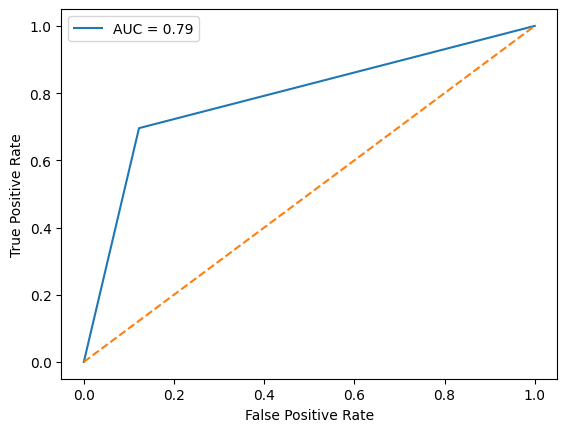

In [40]:
#PLOT ROC CURVE
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

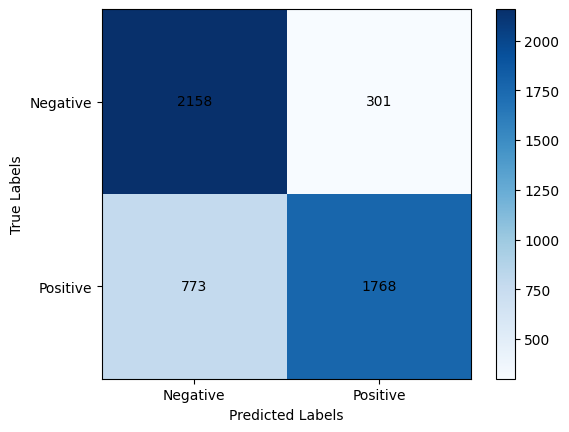

In [41]:
#PLOT CONFUSION MATRIX
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.show()

In [42]:
#PRINT THE PERFORMANCE METRICS with 100d LR MODEL with 20 epoch
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(f'True Positive: {tp}')
print(f'False Positive: {fp}')
print(f'True Negative: {tn}')
print(f'False Negative: {fn}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

True Positive: 1768
False Positive: 301
True Negative: 2158
False Negative: 773
Accuracy: 0.7852
Precision: 0.8545
Recall: 0.6958
F1 Score: 0.7670
